In [1]:
# import the necessary packages
import torch
import os

IMAGE_TRAIN_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/train"
MASK_TRAIN_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/train_labels"
IMAGE_TEST_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/test"
MASK_TEST_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/test_labels"
IMAGE_VALID_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/val"
MASK_VALID_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/val_labels"

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256
# define threshold to filter weak predictions
THRESHOLD = 0.5

In [3]:
import numpy as np
from PIL import Image
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, transform=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.transform  = transform
        if is_train == True:
            x = round(len(os.listdir(input_dir)) * .8)
            self.images = os.listdir(input_dir)[:x]
        else:
            x = round(len(os.listdir(input_dir)) * .8)
            self.images = os.listdir(input_dir)[x:]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index])
        mask_path   = mask_path[:-1]
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]
        
        return img, mask

In [6]:
train_transform = A.Compose(
    [
        A.Resize(height=INPUT_IMAGE_HEIGHT, width=INPUT_IMAGE_WIDTH),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=INPUT_IMAGE_HEIGHT, width=INPUT_IMAGE_WIDTH),
        ToTensorV2(),
    ],
)

In [7]:
def get_loaders( inp_dir, mask_dir,batch_size,
			     train_transform):
    
    train_ds     = SegmentationDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=True, transform=train_transform)

    train_loader = DataLoader( train_ds, batch_size=batch_size, shuffle=True )

    return train_loader

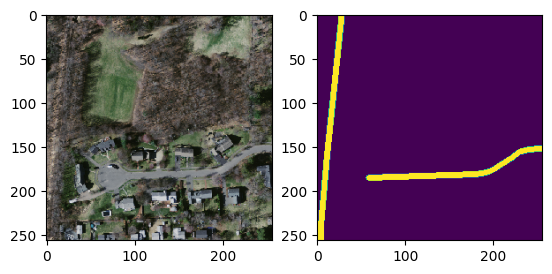

In [8]:
train_loader = get_loaders( IMAGE_TRAIN_DATASET_PATH, MASK_TRAIN_DATASET_PATH,
                            BATCH_SIZE,  train_transform)

val_loader = get_loaders( IMAGE_VALID_DATASET_PATH, MASK_VALID_DATASET_PATH,
                            BATCH_SIZE,  val_transform)

test_loader = get_loaders( IMAGE_TEST_DATASET_PATH, MASK_TEST_DATASET_PATH,
                            BATCH_SIZE,  val_transform)

inputs, masks = next(iter(train_loader))

_, ax = plt.subplots(1,2)
ax[0].imshow(inputs[0].permute(1,2,0))
ax[1].imshow(masks[0])

In [9]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    model.eval()

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float()
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask).sum()) / (
                (preds + mask).sum() + 1e-7
            )

    print(
        f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)*100:.2f}")
    model.train()

In [10]:
model = smp.Unet(encoder_name='efficientnet-b3', in_channels=3, classes=1, activation=None).to(DEVICE)
loss_fn   = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR)

In [11]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    for batch_idx, (image, mask) in enumerate(loop):
        image   = image.to(device=DEVICE)
        mask    = mask.float().unsqueeze(1).to(device=DEVICE)

        # forward
        predictions = model(image)
        loss = loss_fn(predictions, mask)

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [12]:
for epoch in range(NUM_EPOCHS):

    print('########################## epoch: '+str(epoch))
    train_fn(train_loader, model, optimizer, loss_fn)
    
    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

########################## epoch: 0


 23%|██▎       | 167/742 [01:25<04:54,  1.95it/s, loss=0.069] 


IsADirectoryError: [Errno 21] Is a directory: '/usr/src/app/roads_dataset_cropped/tiff/train/.ipynb_checkpoints'

IndexError: index 2 is out of bounds for axis 0 with size 2

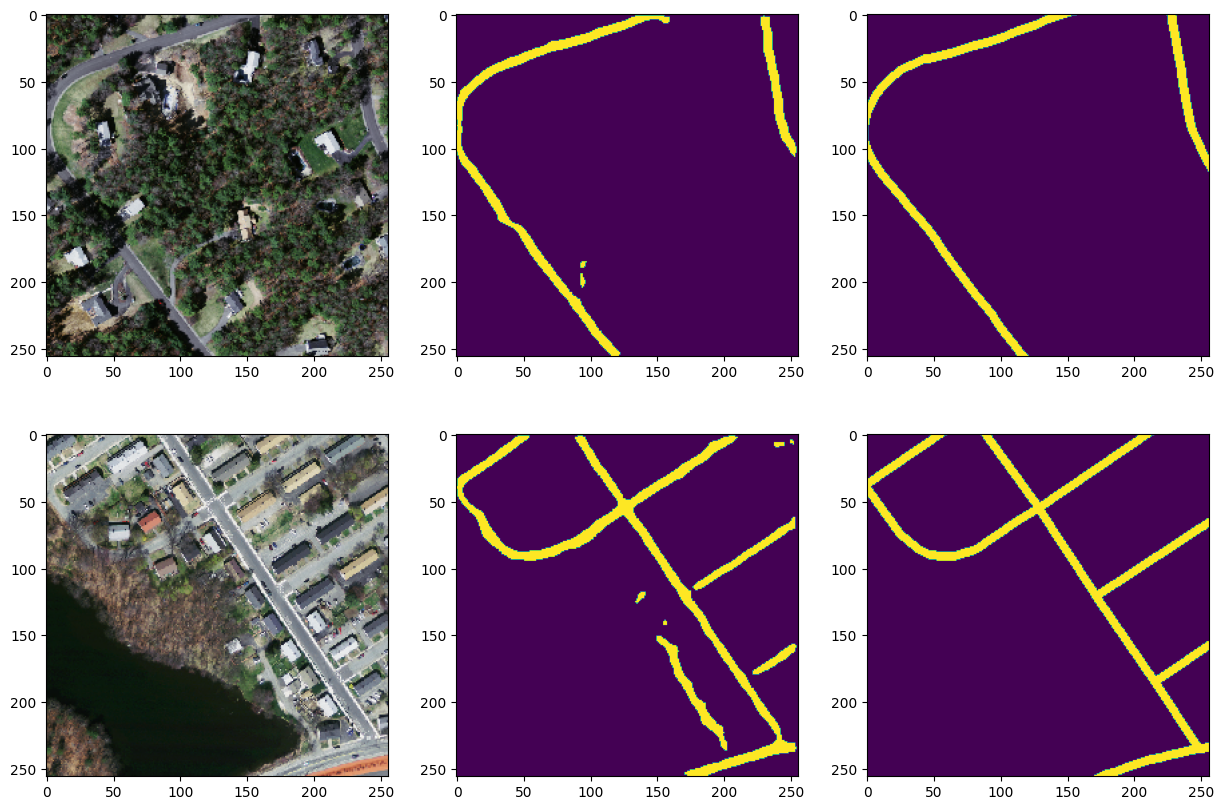

In [17]:
inputs, masks = next(iter(test_loader))
output        = ((torch.sigmoid(model(inputs.to('cuda')))) >0.5).float()
_, ax = plt.subplots(2,3, figsize=(15,10))
for k in range(10):
    ax[k][0].imshow(inputs[k].permute(1,2,0))
    ax[k][1].imshow(output[k][0].cpu())
    ax[k][2].imshow(masks[k])